## Step 1 : Loading CIFAR-10 dataset

In [4]:
#import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
#define a transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#load CIFAR-10 with basic transform
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


In [6]:
#check dataset loaded correctly
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Number of training samples: 50000
Number of test samples: 10000


## Step 2 : Basic architecture

### 2:1 Intermediate Block

In [7]:
#define a class for intermdiate block
class IntermediateBlock(nn.Module):
    def __init__(self, input_channels, output_channels, num_paths):
        super().__init__() #initiliase internals
        self.num_paths = num_paths #store a number of parallel conventional paths
        self.convs = nn.ModuleList([
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
            for _ in range(num_paths)
        ])
        self.attention = nn.Linear(input_channels, num_paths)

    def forward(self, images): #get the shape of the input tensor
        batch_size, c, h, w = images.size()

        #average over height and width for each channel
        global_summary = images.mean(dim=[2, 3])  #shape: [batch_size, input_channels]

        #get soft weights from the attention layer
        weights = F.softmax(self.attention(global_summary), dim=1)  #shape: [batch_size, num_paths]

        #run input through all conv layers
        conv_outputs = torch.stack([conv(images) for conv in self.convs], dim=1)
        #shape: [batch_size, num_paths, output_channels, h, w]

        #reshape weights to match conv output shape
        weights = weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        #shape: [batch_size, num_paths, 1, 1, 1]

        #apply weights and combine conv outputs
        mixed_output = (conv_outputs * weights).sum(dim=1)  #shape: [batch_size, output_channels, h, w]

        return mixed_output

### 2:2 Output Block

In [8]:
#define a class for the output block
class OutputBlock(nn.Module):
    def __init__(self, input_channels, hidden_units=0):
        super().__init__()  # initialise internals

        #if a hidden layer is desired
        if hidden_units > 0:
            self.network = nn.Sequential(
                nn.Linear(input_channels, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, 10)               #final output layer (10 classes)
            )
        else:
            self.network = nn.Linear(input_channels, 10)  #if no hidden layer then single FC layer

    def forward(self, images):
        #compute mean activation value for each channel
        global_summary = images.mean(dim=[2, 3])

        #feed the summary into the classifier
        logits = self.network(global_summary)

        return logits


In [9]:
#define the full network by combining intermediate and output blocks
class CIFAR10Net(nn.Module):
    def __init__(self):
        super().__init__()  #initialise internals

        # first intermediate block: input image has 3 channels (RGB)
        self.block1 = IntermediateBlock(input_channels=3, output_channels=32, num_paths=3)

        #second intermediate block: input is 32 channels from block1
        self.block2 = IntermediateBlock(input_channels=32, output_channels=64, num_paths=3)

        #the output block input is 64 channels from block2
        self.classifier = OutputBlock(input_channels=64, hidden_units=128)

    def forward(self, images):
        #pass the input through the intermediate blocks
        x = self.block1(images)
        x = self.block2(x)

        #pass the result through the output block to get class logits
        logits = self.classifier(x)

        return logits


## Step 3: Training and testing

### Model setup

In [10]:
#test model to check if training components work correctly
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(4 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)



In [11]:
#create the model and move it to the GPU if one is available
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#set the loss function and optimiser (simpler)
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.005)


### Training loop

In [12]:
#store the loss and accuracy values
all_losses = []
train_acc_history = []
test_acc_history = []

#number of training rounds 100
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_preds = 0
    total_samples = 0

    #train on each batch
    for batch_imgs, batch_labels in train_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)

        predictions = model(batch_imgs)
        loss = loss_func(predictions, batch_labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        all_losses.append(loss.item())
        _, preds = torch.max(predictions, 1)
        correct_preds += (preds == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    train_acc = correct_preds / total_samples
    train_acc_history.append(train_acc)

    #evaluate on test set
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            test_out = model(test_imgs)
            _, test_preds = torch.max(test_out, 1)
            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.size(0)

    test_acc = test_correct / test_total
    test_acc_history.append(test_acc)

    #print output
    print(f"Epoch {epoch+1}: Training Accuracy = {train_acc * 100:.2f}%, Test Accuracy = {test_acc * 100:.2f}%")


Epoch 1: Training Accuracy = 21.71%, Test Accuracy = 29.79%
Epoch 2: Training Accuracy = 31.84%, Test Accuracy = 34.51%
Epoch 3: Training Accuracy = 35.66%, Test Accuracy = 37.53%
Epoch 4: Training Accuracy = 37.84%, Test Accuracy = 39.09%
Epoch 5: Training Accuracy = 39.38%, Test Accuracy = 40.09%
Epoch 6: Training Accuracy = 40.67%, Test Accuracy = 41.07%
Epoch 7: Training Accuracy = 41.73%, Test Accuracy = 42.27%
Epoch 8: Training Accuracy = 42.71%, Test Accuracy = 42.85%
Epoch 9: Training Accuracy = 43.50%, Test Accuracy = 43.42%
Epoch 10: Training Accuracy = 44.32%, Test Accuracy = 44.08%
Epoch 11: Training Accuracy = 45.01%, Test Accuracy = 44.84%
Epoch 12: Training Accuracy = 45.57%, Test Accuracy = 45.04%
Epoch 13: Training Accuracy = 45.98%, Test Accuracy = 45.48%
Epoch 14: Training Accuracy = 46.55%, Test Accuracy = 46.46%
Epoch 15: Training Accuracy = 46.67%, Test Accuracy = 46.35%
Epoch 16: Training Accuracy = 47.04%, Test Accuracy = 46.84%
Epoch 17: Training Accuracy = 47.

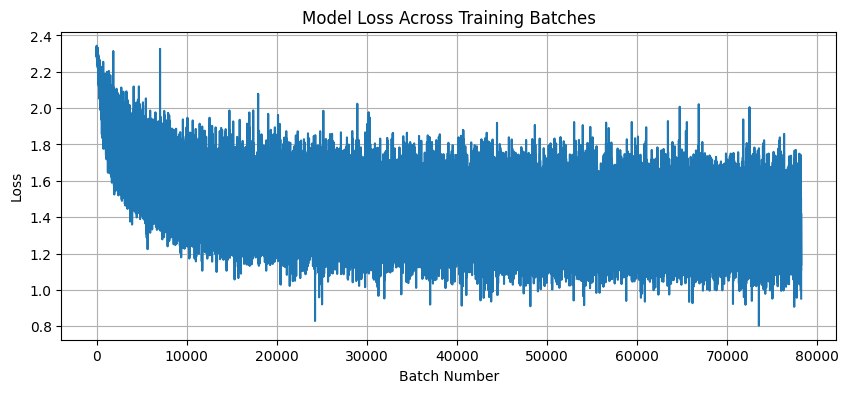

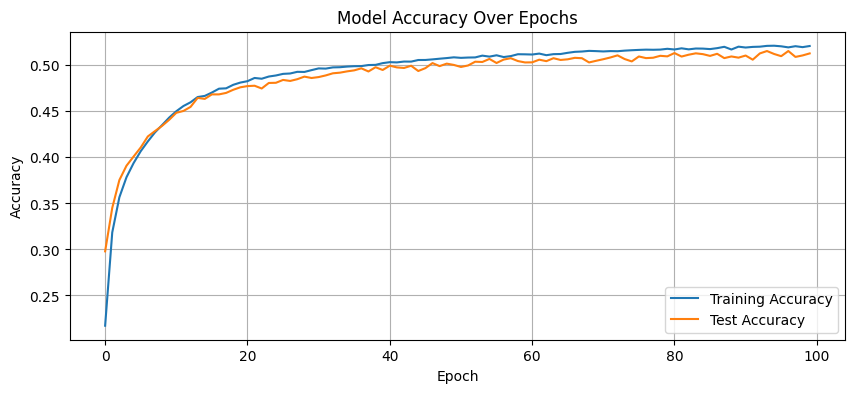

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(all_losses)
plt.title("Model Loss Across Training Batches")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Step 4: Improving your results

In [14]:
#intermediateBlock with attention-based weighted convs and dropout
class IntermediateBlock(nn.Module):
    def __init__(self, input_channels, output_channels, num_paths=3):
        super().__init__()

        #create 3 convolutional paths with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=k, padding=k//2),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
                nn.Dropout(0.3)
            )
            for k in [1, 3, 5]
        ])

        #fully connected layer to compute attention weights from channel averages
        self.attention = nn.Linear(input_channels, num_paths)

        #shortcut connection to preserve input if shape matches; otherwise project it
        self.shortcut = nn.Identity() if input_channels == output_channels else nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, images):
        shortcut = self.shortcut(images)
        global_summary = images.mean(dim=[2, 3])

        weights = F.softmax(self.attention(global_summary), dim=1)

        conv_outputs = [conv(images) for conv in self.convs]
        combined = sum(weights[:, i].view(-1, 1, 1, 1) * conv_outputs[i] for i in range(len(self.convs)))

        return combined + shortcut


In [15]:
#final output block- global average pooling + fully connected classifier
class OutputBlock(nn.Module):
    def __init__(self, input_channels, hidden_units=512):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_channels, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_units, 10)  #output logits for 10 classes
        )

    def forward(self, images):
        global_summary = images.mean(dim=[2, 3])  #global average pooling
        return self.fc(global_summary)

In [16]:
#full model made up of 6 IntermediateBlocks + final OutputBlock
class CIFAR10Net(nn.Module):
    def __init__(self):
        super().__init__()

        #deep architecture = more learning capacity
        self.block1 = IntermediateBlock(3, 64)
        self.block2 = IntermediateBlock(64, 64)
        self.block3 = IntermediateBlock(64, 64)
        self.block4 = IntermediateBlock(64, 64)
        self.block5 = IntermediateBlock(64, 64)
        self.block6 = IntermediateBlock(64, 64)

        #and output classifier
        self.classifier = OutputBlock(64, hidden_units=512)

    def forward(self, images):
        x = self.block1(images)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        return self.classifier(x)


In [17]:
#advanced data augmentation to improve generalisation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  #slight distortions
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#normalisation only for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#load CIFAR-10 with transformations
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

#larger batch size for better gradient estimation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


In [18]:
#setup model training
model = CIFAR10Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_func = nn.CrossEntropyLoss()

optimiser = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=200)


In [11]:
#track the metrics
all_losses = []
train_acc_history = []
test_acc_history = []

num_epochs = 120

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_preds = 0
    total_samples = 0

    for batch_imgs, batch_labels in train_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)

        predictions = model(batch_imgs)
        loss = loss_func(predictions, batch_labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        all_losses.append(loss.item())
        _, preds = torch.max(predictions, 1)
        correct_preds += (preds == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    train_acc = correct_preds / total_samples
    train_acc_history.append(train_acc)

    #evaluation
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            test_out = model(test_imgs)
            _, test_preds = torch.max(test_out, 1)
            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.size(0)

    test_acc = test_correct / test_total
    test_acc_history.append(test_acc)
    scheduler.step()

    #print output
    print(f"Epoch {epoch+1}: Training Accuracy = {train_acc * 100:.2f}%, Test Accuracy = {test_acc * 100:.2f}%")


Epoch 1: Training Accuracy = 87.09%, Test Accuracy = 86.05%
Epoch 2: Training Accuracy = 87.34%, Test Accuracy = 86.83%
Epoch 3: Training Accuracy = 87.18%, Test Accuracy = 86.91%
Epoch 4: Training Accuracy = 87.05%, Test Accuracy = 86.51%
Epoch 5: Training Accuracy = 87.19%, Test Accuracy = 86.42%
Epoch 6: Training Accuracy = 87.47%, Test Accuracy = 87.46%
Epoch 7: Training Accuracy = 87.31%, Test Accuracy = 86.09%
Epoch 8: Training Accuracy = 87.49%, Test Accuracy = 83.79%
Epoch 9: Training Accuracy = 87.57%, Test Accuracy = 86.54%
Epoch 10: Training Accuracy = 87.89%, Test Accuracy = 87.30%
Epoch 11: Training Accuracy = 87.70%, Test Accuracy = 85.96%
Epoch 12: Training Accuracy = 87.95%, Test Accuracy = 87.58%
Epoch 13: Training Accuracy = 87.74%, Test Accuracy = 87.46%
Epoch 14: Training Accuracy = 87.91%, Test Accuracy = 86.48%
Epoch 15: Training Accuracy = 87.81%, Test Accuracy = 86.92%
Epoch 16: Training Accuracy = 88.06%, Test Accuracy = 86.32%
Epoch 17: Training Accuracy = 88.

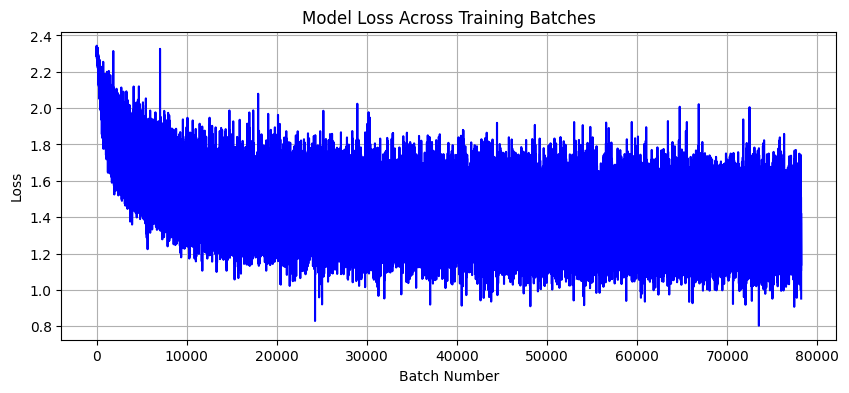

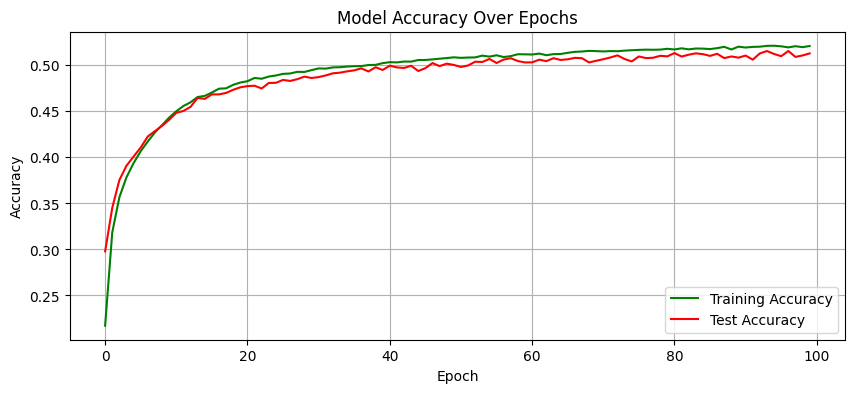

In [26]:
import matplotlib.pyplot as plt

#plot training loss over all batches
plt.figure(figsize=(10, 4))
plt.plot(all_losses, color='blue')
plt.title("Model Loss Across Training Batches")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#plot the accuracy over epochs
plt.figure(figsize=(10, 4))
plt.plot(train_acc_history, label='Training Accuracy', color='green')
plt.plot(test_acc_history, label='Test Accuracy', color='red')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

